# Pre-processing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact
import pycaret
from pycaret.regression import *
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from IPython import display

In [2]:
#load dataframe
#parse datetime column
df=pd.read_csv('~/Test/Springboard/Capstone_COVID19_Weather/Data/state_cov_weather2.csv', parse_dates=[0])
df.set_index('date', inplace= True)

In [3]:
df.tail()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
date,,,,,,,,,,,,,
2021-09-08,72.86,24.1,63.50,0.0,70.16,0.0,71.96,0.0,935.0,111.0,244.0,1475.0,2
2021-09-09,67.46,0.0,62.42,35.3,71.42,3.8,70.88,8.1,626.0,152.0,620.0,2407.0,3
2021-09-10,59.90,0.5,58.46,13.0,66.92,0.0,68.54,7.6,625.0,147.0,506.0,1873.0,4
2021-09-11,63.86,0.0,59.36,0.0,63.14,0.0,59.99,0.3,0.0,199.0,584.0,0.0,5
2021-09-12,69.44,0.3,63.50,0.0,69.44,0.0,71.42,0.0,0.0,180.0,0.0,0.0,6


In [4]:
df_vt=df.drop(columns=['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases', 'CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases', 'MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases','weekday'])

In [5]:
df_me=df.drop(columns=['VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases', 'CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases', 'MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases','weekday'])

In [6]:
df_ma=df.drop(columns=['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases', 'CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases', 'VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases','weekday'])

In [7]:
df_ct= df.drop(columns=['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases', 'VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases', 'MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases','weekday'])

***

In [8]:
# Make duplicates of datasets for processing with Pycaret:
df_vt3 = df_vt.reset_index()
df_ct3 = df_ct.reset_index()
df_me3 = df_me.reset_index()
df_ma3 = df_ma.reset_index()

In [9]:
df_list = [df_ct3, df_ma3, df_me3, df_vt3]

In [10]:
# Add 'day_of_week' and 'day_of_year' columns to each dataframe
for df in df_list:
    df['day_of_week'] = [i.dayofweek for i in df['date']]
    df['day_of_year'] = [i.dayofyear for i in df['date']]
    df['Year'] =[i.year for i in df['date']]
    df['Month'] = [i.month for i in df['date']]
    df['Day'] = [i.day for i in df['date']]

### US Census Bureau state populations
* Massachusetts: 7,029,917 
* Vermont: 643,077	
* Connecticut: 3,605,944	
* Maine: 1,362,359

Source: [U.S. Census Bureau](https://www.census.gov/quickfacts/fact/table/VT,CT,MA,ME/PST045219) April 1, 2020 Census.

Because some states are very densely populated, while others are much more sparsely populated, I'll calculate confirmed Covid cases as a percentage of overall population. 

In order to do this, I'll divide by the appropriate state's total population (as per the April 1, 2020 U.S. Census Bureau), and multiply by 100,000 for ten thousandths of a percent. 

In [11]:
df_ma3['new_case_percent_pop*'] = (df_ma3['MA_Conf_Cases'] / 70.29917)

In [12]:
df_ct3['new_case_percent_pop*'] = (df_ct3['CT_Conf_Cases'] / 36.05944)

In [13]:
df_me3['new_case_percent_pop*'] = (df_me3['ME_Conf_Cases'] / 13.62359)

In [14]:
df_vt3['new_case_percent_pop*'] = (df_vt3['VT_Conf_Cases'] / 6.43077)

Try the model using new cases as ten thousandths of a percent of population, rather than count.

## Using the mean as a baseline prediction model

#### Massachusetts

In [15]:
# Create features
X_ma, y_ma = df_ma3.drop('MA_Conf_Cases', axis =1), df_ma3.MA_Conf_Cases
# Make test and training split
X_train_ma, X_test_ma, y_train_ma, y_test_ma = train_test_split(X_ma, y_ma, test_size = 0.2, random_state=42)
dummy_mean_ma = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_ma.fit(X_train_ma, y_train_ma)
# Get R-squared score
score_mean_ma = dummy_mean_ma.score(X_test_ma, y_test_ma) 
print("The R2 score of using the mean to predict Massachusetts' COVID19 cases is:", score_mean_ma)

The R2 score of using the mean to predict Massachusetts' COVID19 cases is: -0.053284810131488225


#### Connecticut

In [16]:
# Create features
X_ct, y_ct = df_ct3.drop('CT_Conf_Cases', axis =1), df_ct3.CT_Conf_Cases
# Make test and training split
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(X_ct, y_ct, test_size=0.2, random_state=42)
# Create a dummy regressor
dummy_mean_ct = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_ct.fit(X_train_ct, y_train_ct)
# Get R-squared score
score_mean_ct = dummy_mean_ct.score(X_test_ct, y_test_ct) 
print("The R2 score of using the mean to predict Connecticut's COVID19 cases is:", score_mean_ct)

The R2 score of using the mean to predict Connecticut's COVID19 cases is: -0.006702217631290974


#### Vermont

In [17]:
# Create features
X_vt, y_vt = df_vt3.drop('VT_Conf_Cases', axis = 1), df_vt3.VT_Conf_Cases
# Make test and training split
X_train_vt, X_test_vt, y_train_vt, y_test_vt = train_test_split(X_vt, y_vt, test_size = 0.2,random_state=42)
# Create a dummy regressor
dummy_mean_vt = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_vt.fit(X_train_vt, y_train_vt)
# Get R-squared score
score_mean_vt = dummy_mean_vt.score(X_test_vt, y_test_vt) 
print("The R2 score of using the mean to predict Vermont's COVID19 cases is:", score_mean_vt)

The R2 score of using the mean to predict Vermont's COVID19 cases is: -0.013915984644440993


#### Maine

In [18]:
# Create features
X_me, y_me = df_me3.drop('ME_Conf_Cases', axis =1), df_me3.ME_Conf_Cases
# Make test and training split
X_train_me, X_test_me, y_train_me, y_test_me = train_test_split(X_me, y_me, test_size=0.2,random_state=42)
# Create a dummy regressor
dummy_mean_me = DummyRegressor(strategy='mean')
# "Train" dummy regressor
dummy_mean_me.fit(X_train_me, y_train_me)
# Get R-squared score
score_mean_me = dummy_mean_me.score(X_test_me, y_test_me) 
print("The R2 score of using the mean to predict Maine's COVID19 cases is:", score_mean_me)

The R2 score of using the mean to predict Maine's COVID19 cases is: -0.10540068459291052


## Correlation between COVID cases and lagged *tempurature* values

We know that there is a period of incubation between the moment of COVID-19 infection and the manifestation of symptoms, so it might be reasonable to expect a higher correlation between average temperatures and some lagged value of COVID-19 cases. If COVID-19 infection rates truly are correlated with temperature, cases that got tested *because* they manifested symptoms, would likely demonstrate some lag with the temperature on the day they were infected. On the other hand, those cases that get tested regularly (for work, medical reasons, etc.), may not demonstrate much of a lag, if any at all, with the temperature on the day they were infected. It would be worthwhile to explore lagged values of COVID cases to determine if there isn't a higher correlation with a lagged value of cases than with the current value of COVID-19 cases. 

#### Massachusetts temperature lag cross-correlation

In [19]:
df_ma4=df_ma3

In [20]:
temp_cov_lags = {'1_wk': -7, '1.5_wks': -10, '2_wks': -14, '3_wks': -21, '4_wks': -28}
for key, value in temp_cov_lags.items():
    df_ma4[key] = df_ma4['MA_Conf_Cases'].shift(value, axis=0)
df_ma4 = df_ma4.drop(['MA_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
ma_corr = pd.DataFrame(df_ma4.corr())
ma_corr

,MA_Avg_Temp(F),MA_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
MA_Avg_Temp(F),1.000000,-0.628138,-0.628138,-0.617129,-0.604865,-0.591901,-0.546742,-0.497032
MA_Conf_Cases,-0.628138,1.000000,1.000000,0.920939,0.795222,0.839697,0.747557,0.638274
new_case_percent_pop*,-0.628138,1.000000,1.000000,0.920939,0.795222,0.839697,0.747557,0.638274
1_wk,-0.617129,0.920939,0.920939,1.000000,0.833874,0.920121,0.838120,0.745091
1.5_wks,-0.604865,0.795222,0.795222,0.833874,1.000000,0.844313,0.791362,0.714971
2_wks,-0.591901,0.839697,0.839697,0.920121,0.844313,1.000000,0.919334,0.835688
3_wks,-0.546742,0.747557,0.747557,0.838120,0.791362,0.919334,1.000000,0.916362
4_wks,-0.497032,0.638274,0.638274,0.745091,0.714971,0.835688,0.916362,1.000000


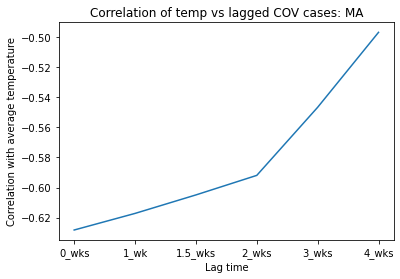

In [21]:
ma_corr.drop(columns=['MA_Avg_Temp(F)', 'new_case_percent_pop*'], inplace=True)
ma_corr.rename(columns={'MA_Conf_Cases': '0_wks'}, inplace=True)
ma_corr.loc['MA_Avg_Temp(F)', :].plot()
plt.title('Correlation of temp vs lagged COV cases: MA')
plt.xlabel('Lag time')
plt.ylabel('Correlation with average temperature')
plt.show()

#### Connecticut temperature lag cross-correlation

In [22]:
df_ct4=df_ct3

In [23]:
for key, value in temp_cov_lags.items():
    df_ct4[key] = df_ct4['CT_Conf_Cases'].shift(value, axis=0)
df_ct4 = df_ct4.drop(['CT_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
ct_corr = pd.DataFrame(df_ct4.corr())
ct_corr

,CT_Avg_Temp(F),CT_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
CT_Avg_Temp(F),1.000000,-0.589089,-0.589089,-0.583183,-0.570396,-0.552986,-0.528611,-0.486397
CT_Conf_Cases,-0.589089,1.000000,1.000000,0.777177,0.650712,0.727060,0.643448,0.568160
new_case_percent_pop*,-0.589089,1.000000,1.000000,0.777177,0.650712,0.727060,0.643448,0.568160
1_wk,-0.583183,0.777177,0.777177,1.000000,0.666420,0.774834,0.724540,0.640356
1.5_wks,-0.570396,0.650712,0.650712,0.666420,1.000000,0.696944,0.663887,0.583644
2_wks,-0.552986,0.727060,0.727060,0.774834,0.696944,1.000000,0.772775,0.721319
3_wks,-0.528611,0.643448,0.643448,0.724540,0.663887,0.772775,1.000000,0.769964
4_wks,-0.486397,0.568160,0.568160,0.640356,0.583644,0.721319,0.769964,1.000000


[]

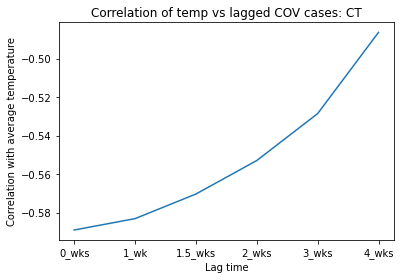

In [24]:
ct_corr.drop(columns=['CT_Avg_Temp(F)', 'new_case_percent_pop*'], inplace=True)
ct_corr.rename(columns={'CT_Conf_Cases': '0_wks'}, inplace=True)
ct_corr.loc['CT_Avg_Temp(F)', :].plot()
plt.title('Correlation of temp vs lagged COV cases: CT')
plt.xlabel('Lag time')
plt.ylabel('Correlation with average temperature')
plt.plot()

#### Vermont temperature lag cross-correlation

In [25]:
df_vt4=df_vt3

In [26]:
for key, value in temp_cov_lags.items():
    df_vt4[key] = df_vt4['VT_Conf_Cases'].shift(value, axis=0)
df_vt4 = df_vt4.drop(['VT_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
vt_corr = pd.DataFrame(df_vt4.corr())
vt_corr

,VT_Avg_Temp(F),VT_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
VT_Avg_Temp(F),1.000000,-0.571510,-0.571510,-0.553044,-0.545564,-0.566260,-0.518298,-0.482696
VT_Conf_Cases,-0.571510,1.000000,1.000000,0.844868,0.734993,0.781832,0.709235,0.644609
new_case_percent_pop*,-0.571510,1.000000,1.000000,0.844868,0.734993,0.781832,0.709235,0.644609
1_wk,-0.553044,0.844868,0.844868,1.000000,0.791469,0.842056,0.782368,0.713320
1.5_wks,-0.545564,0.734993,0.734993,0.791469,1.000000,0.761727,0.725684,0.663498
2_wks,-0.566260,0.781832,0.781832,0.842056,0.761727,1.000000,0.839935,0.779342
3_wks,-0.518298,0.709235,0.709235,0.782368,0.725684,0.839935,1.000000,0.840092
4_wks,-0.482696,0.644609,0.644609,0.713320,0.663498,0.779342,0.840092,1.000000


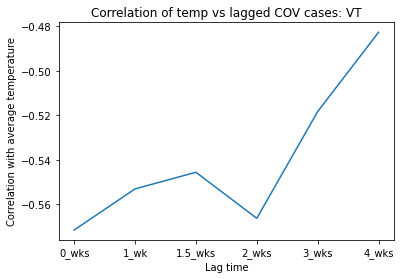

In [27]:
vt_corr.drop(columns=['VT_Avg_Temp(F)', 'new_case_percent_pop*'], inplace=True)
vt_corr.rename(columns={'VT_Conf_Cases': '0_wks'}, inplace=True)
vt_corr.loc['VT_Avg_Temp(F)', :].plot()
plt.title('Correlation of temp vs lagged COV cases: VT')
plt.xlabel('Lag time')
plt.ylabel('Correlation with average temperature')
plt.show()

#### Maine temperature lag cross-correlation

In [28]:
df_me4=df_me3

In [29]:
for key, value in temp_cov_lags.items():
    df_me4[key] = df_me4['ME_Conf_Cases'].shift(value, axis=0)
df_me4 = df_me4.drop(['ME_PRCP(mm)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
me_corr = pd.DataFrame(df_me4.corr())
me_corr

,ME_Avg_Temp(F),ME_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
ME_Avg_Temp(F),1.000000,-0.494485,-0.494485,-0.492485,-0.495851,-0.489141,-0.444906,-0.421420
ME_Conf_Cases,-0.494485,1.000000,1.000000,0.895255,0.758257,0.800753,0.681238,0.547517
new_case_percent_pop*,-0.494485,1.000000,1.000000,0.895255,0.758257,0.800753,0.681238,0.547517
1_wk,-0.492485,0.895255,0.895255,1.000000,0.803828,0.891650,0.786226,0.664028
1.5_wks,-0.495851,0.758257,0.758257,0.803828,1.000000,0.807657,0.744874,0.659837
2_wks,-0.489141,0.800753,0.800753,0.891650,0.807657,1.000000,0.886078,0.770015
3_wks,-0.444906,0.681238,0.681238,0.786226,0.744874,0.886078,1.000000,0.872222
4_wks,-0.421420,0.547517,0.547517,0.664028,0.659837,0.770015,0.872222,1.000000


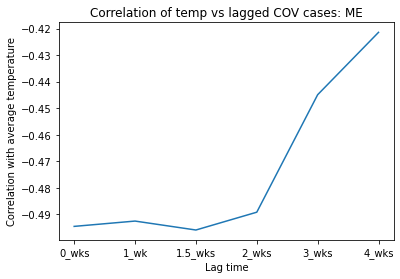

In [30]:
me_corr.drop(columns=['ME_Avg_Temp(F)', 'new_case_percent_pop*'], inplace=True)
me_corr.rename(columns={'ME_Conf_Cases': '0_wks'}, inplace=True)
plt.title('Correlation of temp vs lagged COV cases: ME')
me_corr.loc['ME_Avg_Temp(F)', :].plot()
plt.xlabel('Lag time')
plt.ylabel('Correlation with average temperature')
plt.show()

Maine seems to have the strongest negative correlation between temperature and a 1.5 week lag of COVID-19 cases. Vermont seems to have the strongest negative correlations with current cases, as well as those lagged by two weeks. However, Massachusetts and Connecticut both very clearly have the strongest correlation between temperature and lag 0 (or, current) case values. While it seems that for some states there may be a strong correlation with lagged COVID case values, since 50-75% of the data don't show any increased correlation using lags (and the remaining 25-50% of data disagree on an optimal lagged value), let's stick with our original lag 0 COVID-19 case values.  

In [31]:
lag_cols = ['1_wk', '1.5_wks', '2_wks', '3_wks', '4_wks']
df_list = [df_ma3, df_ct3, df_me3, df_vt3]

In [32]:
for df in df_list:
    df.drop(columns=lag_cols, inplace=True)

## Correlation between COVID cases and lagged *precipitation* values

#### Massachusetts PRCP lag cross-correlation

In [33]:
df_ma4=df_ma3.copy()

In [34]:
prcp_cov_lags = {'1_wk': -7, '1.5_wks': -10, '2_wks': -14, '3_wks': -21, '4_wks': -28}
for key, value in prcp_cov_lags.items():
    df_ma4[key] = df_ma4['MA_Conf_Cases'].shift(value, axis=0)
df_ma4 = df_ma4.drop(['MA_Avg_Temp(F)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
ma_corr = pd.DataFrame(df_ma4.corr())
ma_corr

,MA_PRCP(mm),MA_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
MA_PRCP(mm),1.000000,0.009234,0.009234,0.020513,0.007562,0.032721,0.022007,0.034374
MA_Conf_Cases,0.009234,1.000000,1.000000,0.920939,0.795222,0.839697,0.747557,0.638274
new_case_percent_pop*,0.009234,1.000000,1.000000,0.920939,0.795222,0.839697,0.747557,0.638274
1_wk,0.020513,0.920939,0.920939,1.000000,0.833874,0.920121,0.838120,0.745091
1.5_wks,0.007562,0.795222,0.795222,0.833874,1.000000,0.844313,0.791362,0.714971
2_wks,0.032721,0.839697,0.839697,0.920121,0.844313,1.000000,0.919334,0.835688
3_wks,0.022007,0.747557,0.747557,0.838120,0.791362,0.919334,1.000000,0.916362
4_wks,0.034374,0.638274,0.638274,0.745091,0.714971,0.835688,0.916362,1.000000


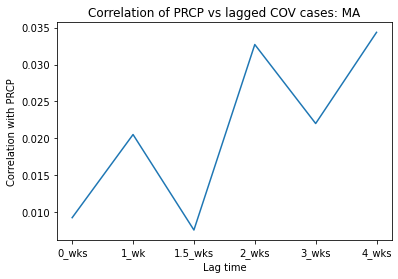

In [35]:
ma_corr.drop(columns=['MA_PRCP(mm)', 'new_case_percent_pop*'], inplace=True)
ma_corr.rename(columns={'MA_Conf_Cases': '0_wks'}, inplace=True)
ma_corr.loc['MA_PRCP(mm)', :].plot()
plt.title('Correlation of PRCP vs lagged COV cases: MA')
plt.xlabel('Lag time')
plt.ylabel('Correlation with PRCP')
plt.show()

#### Connecticut PRCP lag cross-correlation

In [36]:
df_ct4=df_ct3.copy()

In [37]:
for key, value in prcp_cov_lags.items():
    df_ct4[key] = df_ct4['CT_Conf_Cases'].shift(value, axis=0)
df_ct4 = df_ct4.drop(['CT_Avg_Temp(F)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
ct_corr = pd.DataFrame(df_ct4.corr())
ct_corr

,CT_PRCP(mm),CT_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
CT_PRCP(mm),1.000000,0.028828,0.028828,0.037386,-0.018751,0.025447,0.058460,0.029693
CT_Conf_Cases,0.028828,1.000000,1.000000,0.777177,0.650712,0.727060,0.643448,0.568160
new_case_percent_pop*,0.028828,1.000000,1.000000,0.777177,0.650712,0.727060,0.643448,0.568160
1_wk,0.037386,0.777177,0.777177,1.000000,0.666420,0.774834,0.724540,0.640356
1.5_wks,-0.018751,0.650712,0.650712,0.666420,1.000000,0.696944,0.663887,0.583644
2_wks,0.025447,0.727060,0.727060,0.774834,0.696944,1.000000,0.772775,0.721319
3_wks,0.058460,0.643448,0.643448,0.724540,0.663887,0.772775,1.000000,0.769964
4_wks,0.029693,0.568160,0.568160,0.640356,0.583644,0.721319,0.769964,1.000000


[]

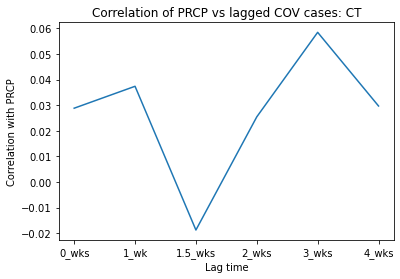

In [38]:
ct_corr.drop(columns=['CT_PRCP(mm)', 'new_case_percent_pop*'], inplace=True)
ct_corr.rename(columns={'CT_Conf_Cases': '0_wks'}, inplace=True)
ct_corr.loc['CT_PRCP(mm)', :].plot()
plt.title('Correlation of PRCP vs lagged COV cases: CT')
plt.xlabel('Lag time')
plt.ylabel('Correlation with PRCP')
plt.plot()

#### Vermont PRCP lag cross-correlation

In [39]:
df_vt4=df_vt3.copy()

In [40]:
for key, value in prcp_cov_lags.items():
    df_vt4[key] = df_vt4['VT_Conf_Cases'].shift(value, axis=0)
df_vt4 = df_vt4.drop(['VT_Avg_Temp(F)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
vt_corr = pd.DataFrame(df_vt4.corr())
vt_corr

,VT_PRCP(mm),VT_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
VT_PRCP(mm),1.000000,-0.043127,-0.043127,-0.065671,-0.064759,-0.042046,-0.053783,-0.032076
VT_Conf_Cases,-0.043127,1.000000,1.000000,0.844868,0.734993,0.781832,0.709235,0.644609
new_case_percent_pop*,-0.043127,1.000000,1.000000,0.844868,0.734993,0.781832,0.709235,0.644609
1_wk,-0.065671,0.844868,0.844868,1.000000,0.791469,0.842056,0.782368,0.713320
1.5_wks,-0.064759,0.734993,0.734993,0.791469,1.000000,0.761727,0.725684,0.663498
2_wks,-0.042046,0.781832,0.781832,0.842056,0.761727,1.000000,0.839935,0.779342
3_wks,-0.053783,0.709235,0.709235,0.782368,0.725684,0.839935,1.000000,0.840092
4_wks,-0.032076,0.644609,0.644609,0.713320,0.663498,0.779342,0.840092,1.000000


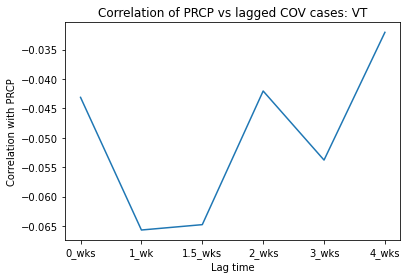

In [41]:
vt_corr.drop(columns=['VT_PRCP(mm)', 'new_case_percent_pop*'], inplace=True)
vt_corr.rename(columns={'VT_Conf_Cases': '0_wks'}, inplace=True)
vt_corr.loc['VT_PRCP(mm)', :].plot()
plt.title('Correlation of PRCP vs lagged COV cases: VT')
plt.xlabel('Lag time')
plt.ylabel('Correlation with PRCP')
plt.show()

#### Maine PRCP lag cross-correlation

In [42]:
df_me4=df_me3.copy()

In [43]:
for key, value in prcp_cov_lags.items():
    df_me4[key] = df_me4['ME_Conf_Cases'].shift(value, axis=0)
df_me4 = df_me4.drop(['ME_Avg_Temp(F)', 'day_of_week', 'day_of_year', 'Year', 'Month', 'Day'], axis =1).dropna()
me_corr = pd.DataFrame(df_me4.corr())
me_corr

,ME_PRCP(mm),ME_Conf_Cases,new_case_percent_pop*,1_wk,1.5_wks,2_wks,3_wks,4_wks
ME_PRCP(mm),1.000000,0.002177,0.002177,0.024677,0.092199,0.027075,0.075240,0.118860
ME_Conf_Cases,0.002177,1.000000,1.000000,0.895255,0.758257,0.800753,0.681238,0.547517
new_case_percent_pop*,0.002177,1.000000,1.000000,0.895255,0.758257,0.800753,0.681238,0.547517
1_wk,0.024677,0.895255,0.895255,1.000000,0.803828,0.891650,0.786226,0.664028
1.5_wks,0.092199,0.758257,0.758257,0.803828,1.000000,0.807657,0.744874,0.659837
2_wks,0.027075,0.800753,0.800753,0.891650,0.807657,1.000000,0.886078,0.770015
3_wks,0.075240,0.681238,0.681238,0.786226,0.744874,0.886078,1.000000,0.872222
4_wks,0.118860,0.547517,0.547517,0.664028,0.659837,0.770015,0.872222,1.000000


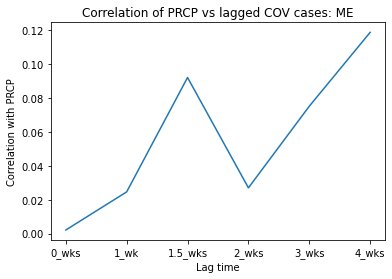

In [44]:
me_corr.drop(columns=['ME_PRCP(mm)', 'new_case_percent_pop*'], inplace=True)
me_corr.rename(columns={'ME_Conf_Cases': '0_wks'}, inplace=True)
plt.title('Correlation of PRCP vs lagged COV cases: ME')
me_corr.loc['ME_PRCP(mm)', :].plot()
plt.xlabel('Lag time')
plt.ylabel('Correlation with PRCP')
plt.show()

In [45]:
lag_cols = ['1_wk', '1.5_wks', '2_wks', '3_wks', '4_wks']
df_list = [df_ma4, df_ct4, df_me4, df_vt4]

In [46]:
for df in df_list:
    df.drop(columns=lag_cols, inplace=True)

## Merge state dataframes back into one dataframe

In order to do this, first we'll make a separate column in each state's dataframe indicating state_id. With this new identifier column, we'll no longer need state-specific identifiers in the column names themselves, and we can update each state's column names to mirror each other in preparation for the merge. Before we do this, we can go ahead and drop the PRCP columns for each state, as precipitation has proved to have little correlation with (and even less predictive power of) COVID19 cases.

In [47]:
# Create identifying state_id columns for each state df
df_ma3['state_id'] = 'MA'
df_ct3['state_id'] = 'CT'
df_vt3['state_id'] = 'VT'
df_me3['state_id'] = 'ME'

In [48]:
# Prepare df_ma3 for merge by updating column names
df_ma3.drop('MA_PRCP(mm)', axis=1, inplace=True)
ma_cols = {'MA_Avg_Temp(F)': 'Avg_Temp(F)',
           'MA_Conf_Cases' : 'Conf_Cases'}
df_ma3.rename(columns=ma_cols, inplace=True)

In [49]:
# Prepare df_ct3 for merge by updating column names
df_ct3.drop('CT_PRCP(mm)', axis=1, inplace=True)
ct_cols = {'CT_Avg_Temp(F)': 'Avg_Temp(F)',
           'CT_Conf_Cases' : 'Conf_Cases'}
df_ct3.rename(columns=ct_cols, inplace=True)

In [50]:
# Prepare df_vt3 for merge by updating column names
df_vt3.drop('VT_PRCP(mm)', axis=1, inplace=True)
vt_cols = {'VT_Avg_Temp(F)': 'Avg_Temp(F)',
           'VT_Conf_Cases' : 'Conf_Cases'}
df_vt3.rename(columns=vt_cols, inplace=True)

In [51]:
# Prepare df_me3 for merge by updating column names
df_me3.drop('ME_PRCP(mm)', axis=1, inplace=True)
me_cols = {'ME_Avg_Temp(F)': 'Avg_Temp(F)',
           'ME_Conf_Cases' : 'Conf_Cases'}
df_me3.rename(columns=me_cols, inplace=True)

In [52]:
df = pd.concat([df_ma3, df_me3, df_vt3, df_ct3], axis=0).set_index('date').reset_index()

In [53]:
# save the data to a new csv file
df.to_csv('COVID19_modeling.csv')

## Mapping with geopandas

In [54]:
fp = '~/Test/Springboard/Capstone_COVID19_Weather/Data/geo_export/geo_export_13390475-3a1c-4c1a-b57d-965976a165df.shp'
states = (gpd.read_file(fp)).to_crs("EPSG:3395")

In [55]:
states2= states.copy()

In [56]:
states2.drop(columns=['drawseq'], inplace=True)

In [57]:
cov_states = states2[states2['state_abbr'].isin(['MA', 'ME', 'CT', 'VT'])]

In [58]:
new_df = pd.DataFrame({'state_abbr':['MA', 'ME', 'CT', 'VT'],
        'total_cases':[df_ma4['MA_Conf_Cases'].sum(), df_me4['ME_Conf_Cases'].sum(), 
                       df_ct4['CT_Conf_Cases'].sum(), df_vt4['VT_Conf_Cases'].sum()]})

In [59]:
new_df = pd.merge(cov_states, new_df, on='state_abbr')

In [60]:
def map_col(col, df, title):
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(22, 14))
    # create map
    df.plot(column=col, cmap='flare', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
    # remove the axis
    ax.axis('off')
    # add a title & annotate
    ax.set_title(title, fontdict={'fontsize': '14', 'fontweight' : '3'})
    df.apply(lambda x: ax.annotate(s=x.state_name + "\n" + str(round(x.total_cases)), 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha='center', 
                                   fontsize=14, 
                                   color='#ffe6cc'),axis=1)
    plt.savefig(title)
    plt.show()

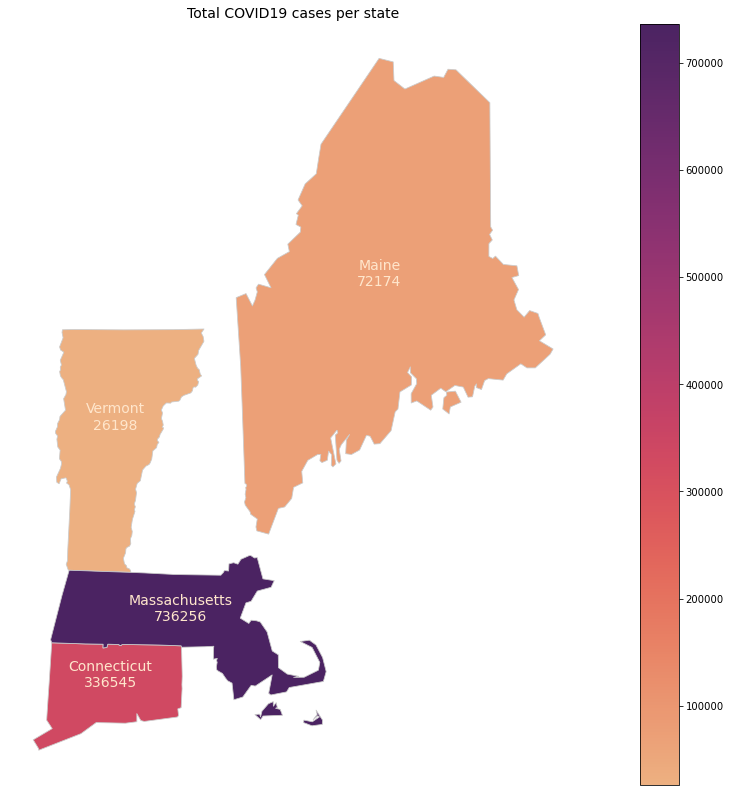

In [61]:
map_col('total_cases', new_df, 'Total COVID19 cases per state')

In [62]:
start_date = datetime(2020, 3, 1)
end_date = datetime(2021, 9, 12)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime('%d/%m/%Y'), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Date',
    orientation='horizontal',
    layout={'width': '600px'}
)

#selection_range_slider

In [63]:
merged_df = pd.DataFrame()
for i in df.date.unique():
    mergetemp =cov_states.merge(df[df.date==i],left_on='state_abbr' ,right_on='state_id',how='left')
    merged_df = merged_df.append(mergetemp)
def cov_plot(date):
    merged_df[merged_df.date==date[0]].plot(column='new_case_percent_pop*',figsize=(20,9), legend = True)

interact(cov_plot,date=selection_range_slider)

interactive(children=(SelectionRangeSlider(description='Date', index=(0, 560), layout=Layout(width='600px'), o…

<function __main__.cov_plot(date)>

## Moving average plots

In [ ]:
'''
for i in df['state_id'].unique():
    subset = df[df['state_id'] == i]
    subset.loc[:,'moving_average'] = subset['new_case_percent_pop*'].rolling(7).mean()
    fig = px.line(subset, x="date", y=["new_case_percent_pop*","moving_average"], title = (i + ' weekly rolling average'), template = 'plotly_dark')
    fig.show()
    #plt.savefig(i)
    #plt.show()
'''

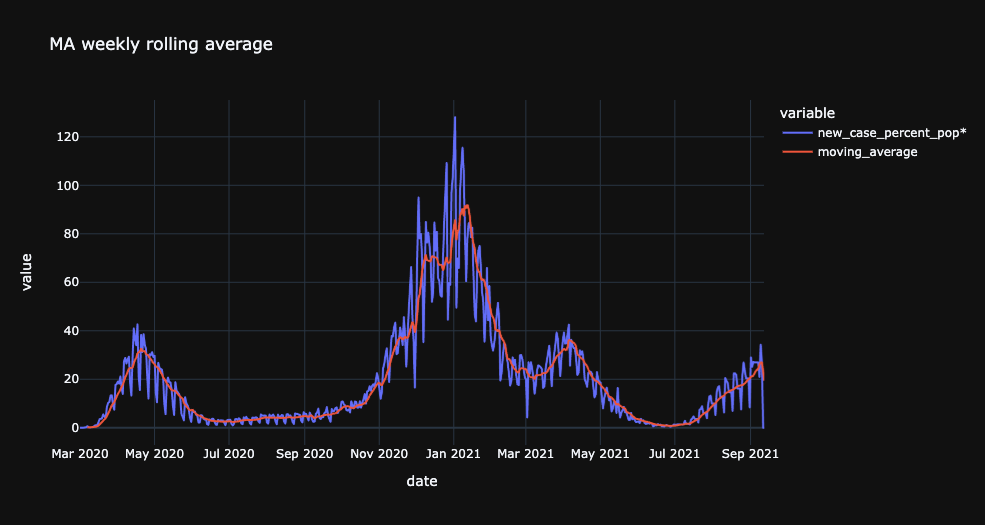

In [64]:
display.Image("Data/png/MA_weekly_rolling_average_cases.png")

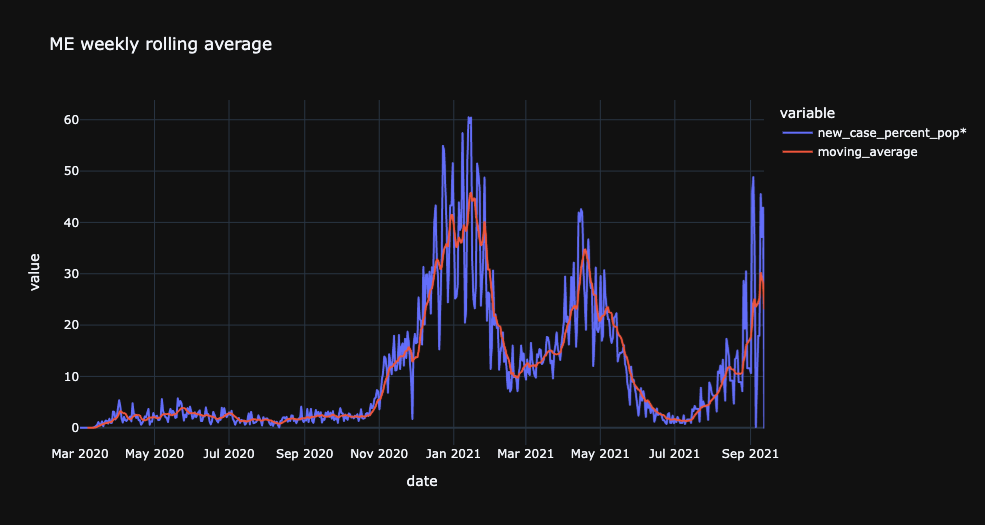

In [65]:
display.Image("Data/png/ME_weekly_rolling_average_cases.png")

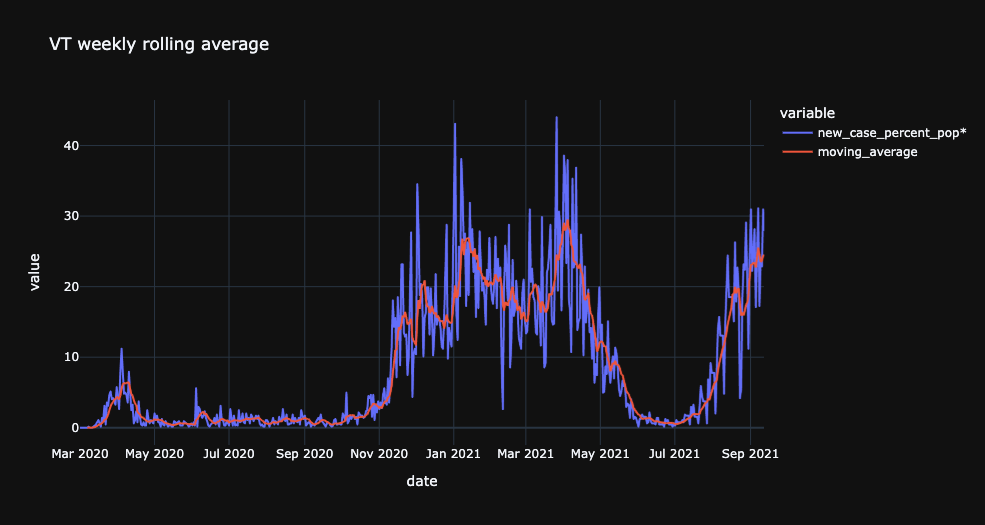

In [66]:
display.Image("Data/png/VT_weekly_rolling_average_cases.png")

In [ ]:
display.Image("Data/png/CT_weekly_rolling_average_cases.png")

In [ ]:
'''
for i in df['state_id'].unique():
    subset = df[df['state_id'] == i]
    subset.loc[:,'moving_average'] = subset['new_case_percent_pop*'].rolling(14).mean()
    fig = px.line(subset, x="date", y=["new_case_percent_pop*","moving_average"], title = (i + ' weekly rolling average'), template = 'plotly_dark')
    fig.show()
'''

## Determining optimal models with pycaret

In [ ]:
df.dtypes

In [ ]:
all_ts = df['state_id'].unique()

all_results = []
#final_model = {}

for i in all_ts:
    df_subset = df[df['state_id'] == i]
    
    # initialize setup from pycaret.regression
    s = setup(df_subset, target ='new_case_percent_pop*' , train_size = 0.8,
              data_split_shuffle = True, fold = 3,
              ignore_features = ['date', 'Conf_Cases'],
              numeric_features = ['day_of_year', 'Year', 'Avg_Temp(F)'],
              categorical_features = ['Month', 'day_of_week'],
              silent = True, verbose = False, session_id = 123, normalize=False)
    # compare all models and select best one based on MAE
    best_model = compare_models(sort = 'R2', verbose=False)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
best = compare_models(sort = 'R2')
best

In [ ]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

Without any hyperparameter tuning, pycaret has determined that a CatBoost Regressor produced the best model metrics for Massachusetts, Maine, and Connecticut, and a Random Forest Regressor produced the best model metrics for Vermont. The top three performing models (using $R^2$ as the evaluation metric) on the entire dataset (including all four states) were: CatBoost Regressor, Random Forest Regressor, and Gradient Boosting Regressor (in that order).

Let's try one-hot-encoding some, and then all, of the categorical columns in the dataset and see if that helps or hurts model performance.

***

## pycaret: One-hot-encoding categorical column: 'state_id'

While a CatBoost Regressor would certainly be able to accomodate our categorical columns, most other ML models can't handle category objects. Let's try one-hot-encoding the `state_id` column and compare pycaret's top performing models and metrics. 

In [ ]:
#one-hot-encode data
one_hot_encoded_data = pd.get_dummies(df, columns = ['state_id'])

In [ ]:
one_hot_encoded_data

In [ ]:
s = setup(one_hot_encoded_data, target ='new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'Conf_Cases'],
            numeric_features = ['day_of_year', 'Year', 'Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week', 'state_id_MA', 'state_id_CT', 'state_id_VT', 'state_id_ME'],
            silent = True, verbose = False, session_id = 123, normalize=False)
    # compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
    # capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str(i)
all_results.append(p)
best = compare_models(sort = 'R2')
best

Interestingly, we see a somewhat significant improvement in $R^2$ when we one-hot-encode the `state_id` column. It also appears that the Extra Trees Regressor now outperforms the Gradient Boosting Regressor. 

Let's check and see if one-hot-encoding the other categorical columns continues to improve model performance!

In [ ]:
# save the data to a new csv file
#one_hot_encoded_data.to_csv('ohe_data.csv')

## pycaret: One-hot-encoding all categorical data: state_id, Month, day_of_week

Let's now one-hot-encode each of our categorical columns (`state_id`, `Month`, and `day_of_week`) and re-run pycaret to see if we can further improve the model metrics.

In [ ]:
#one-hot-encode data
one_hot_encoded_data3 = pd.get_dummies(df, columns = ['state_id', 'Month', 'day_of_week'])

In [ ]:
one_hot_encoded_data3.columns

In [ ]:
s = setup(one_hot_encoded_data3, target ='new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'Conf_Cases'],
            numeric_features = ['day_of_year', 'Year', 'Avg_Temp(F)'],
            categorical_features = ['state_id_CT', 'state_id_MA', 'state_id_ME',
                                       'state_id_VT', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
                                       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                                       'Month_12', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
                                       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
            silent = True, verbose = False, session_id = 123, normalize=False)
    # compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
    # capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str(i)
all_results.append(p)
best = compare_models(sort = 'R2')
best

Even better! One-hot-encoding all three categorical columns produced the best model metrics yet! Let's save the dataset with these columns one-hot-encoded and begin tuning the hyperparameters of a CatBoost Regressor, Extra Trees Regressor, and Random Forest Regressor to feed into a Voting Regressor in the next steps.

In [ ]:
# save the data to a new csv file
#one_hot_encoded_data3.to_csv('ohe_data2.csv')

*****

In [ ]:
'''
s = setup(one_hot_encoded_data, target ='new_case_percent_pop*', train_size = 0.8,
            data_split_shuffle = True, fold = 3,
            ignore_features = ['date', 'Conf_Cases'],
            numeric_features = ['day_of_year', 'Year', 'Avg_Temp(F)'],
            categorical_features = ['Month', 'day_of_week', 'state_id_MA', 'state_id_CT', 'state_id_VT', 'state_id_ME'],
            silent = True, verbose = False, session_id = 123, normalize=True)
    # compare all models and select best one based on MAE
best_model = compare_models(sort = 'R2', verbose=False)
    
    # capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str(i)
all_results.append(p)
best = compare_models(sort = 'R2')
best
'''